In [1]:
import dlib
import cv2 as cv
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Find face landmarks  
Find some corresponding face landmarks between start and end images and display them. This can be done manually, or using an automatic facial landmark detector, to find salient points such as on the eyebrows, corners of the eyes etc… An example of such a detector is dlib which provides 68 facial landmarks on the eyes, nose, mouth, eye-brows and jaw. You could even add a few more points manually. The more points the better the final result (but remember that they need to be corresponding points i.e. you need to click on the same semantic point on both faces). I would recommend that you debug on a smaller number of points and once you are sure your algorithm works add more to increase the quality. You will get the same grade if you do thismanually or with a landmark detector. This is not the important part of the coursework.

In [2]:
def image_resize(img, size):
    img = cv.resize(img, size)
    return img

Get 68 landmarks from DLIB

In [3]:
def get_dlib_face_landmark(detector, predictor, img):
    dets = detector(img, 0)
    d = dets[0]
    shape = predictor(img, d)
    points = np.zeros((68, 2))
    for i in range(68):
        points[i][0] = shape.part(i).x
        points[i][1] = shape.part(i).y
    return points.astype(int)

Display landmarks by adding circles and text on each point.

In [4]:
def display_face_landmark(img, points, ax):
    n = points.shape[0]
    for i in range(n):
        cv.circle(img, (points[i][0], points[i][1]), 2, (0, 255, 0), -1, 1)
        cv.putText(img, str(i), (points[i][0], points[i][1]), cv.FONT_HERSHEY_SIMPLEX, 0.2, (255, 0, 0), 1)
    # cv.imshow('Face Landmark ' + str(n), img)
    # cv.waitKey(0)
    ax.imshow(img[:,:,::-1])

Run this function to manually add points by clicking on the image. It will return array of points.

In [5]:
def add_points_manually(img):
    points = []
    tmp = img.copy()
    def on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            xy = "(%d, %d)" % (x, y)
            cv.circle(tmp, (x, y), 2, (0, 255, 0), -1, 1)
            cv.putText(tmp, xy, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255))
            cv.imshow('image', tmp)
            points.append([x, y])
    
    cv.namedWindow('image')
    cv.setMouseCallback('image', on_EVENT_LBUTTONDOWN)
    while(1):
        cv.imshow('image', tmp)
        if cv.waitKey(0) & 0xFF == 27:
            break
    cv.destroyAllWindows()
    return points

Read images and resize them to the same size.

In [6]:
img1_path = "Face_3.jpg"
img2_path = 'Face_4.jpg'
img1_raw = cv.imread(img1_path)
img2_raw = cv.imread(img2_path)
img1 = image_resize(img1_raw, (300, 300))
img2 = image_resize(img2_raw, (300, 300))

Run this block to generate landmarks using DLIB.

In [7]:
# predictor_path  = "shape_predictor_68_face_landmarks.dat"
# detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor(predictor_path)
# points_1 = get_dlib_face_landmark(detector, predictor, img1)
# points_2 = get_dlib_face_landmark(detector, predictor, img2)

If you do not have DLIB enviornment, load 'landmark.npz' to get pre-saved landmarks.

In [7]:
loaded_data = np.load('landmark.npz')
points_1 = loaded_data['points_1']
points_2 = loaded_data['points_2']

Uncomment below two blocks to add points manually. The programme performs well without extra points.

In [8]:
# new_points = add_points_manually(img1)
# points_1 = np.vstack((points_1, new_points))

In [9]:
# new_points = add_points_manually(img2)
# points_2 = np.vstack((points_2, new_points))

Add points on the edge of each image to implement triangulation on the whole image. Otherwise morphing will only work on the face instead of the whole image.

In [10]:
# Add points on the edge of image, so triangulation can cover the whole image
h, w = img1.shape[:2]
edge_points = np.asarray([[0,0], [0, w//2], [0, w-1], [h//2, 0], [h//2, w-1], [h-1, 0], [h-1, w//2], [h-1, w-1]])
points_1 = np.vstack((points_1, edge_points))
points_2 = np.vstack((points_2, edge_points))

Display all the landmarks on each image.

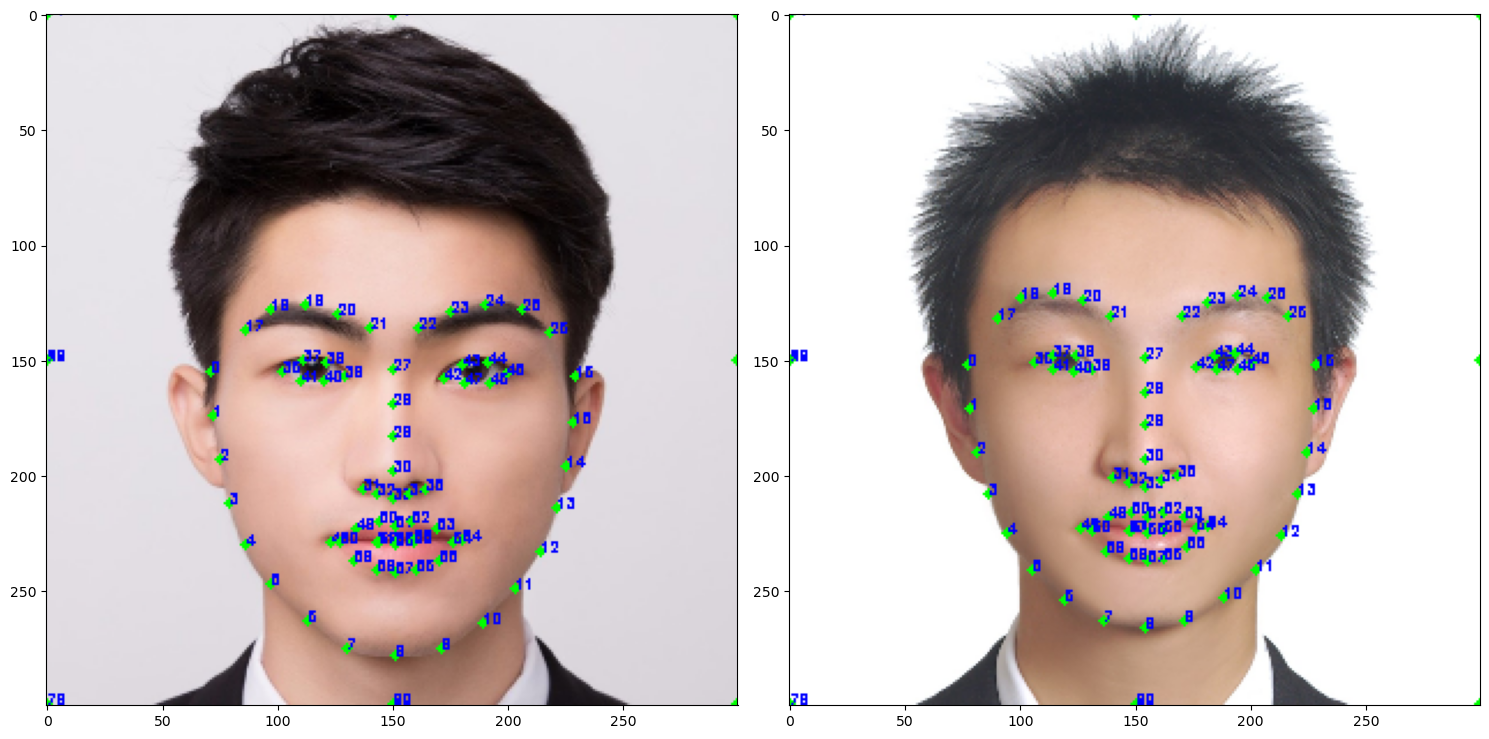

In [11]:
# Display whether the landmark points are add properly
fig, axs = plt.subplots(1, 2, figsize=(15,10))
display_face_landmark(img1.copy(), points_1, axs[0])
display_face_landmark(img2.copy(), points_2, axs[1])
fig.tight_layout()
plt.show()

# Triangulation and Visualise
Create a triangulation and visualise it. Again, you can do this manually or you can use the standard Delaunay Triangulation algorithm to do it automatically. Your output should be a list of triangle vertices for each image. The order of the triangles and the vertices should reflect the correspondences between triangles and vertices.

In [12]:
def display_triangulation(img, points, triangles, ax):
    for tri in triangles:
        point1 = points[tri[0]]
        point2 = points[tri[1]]
        point3 = points[tri[2]]
        cv.line(img, point1, point2, (255, 0, 0), 1)
        cv.line(img, point2, point3, (255, 0, 0), 1)
        cv.line(img, point3, point1, (255, 0, 0), 1)
    for point in points:
        cv.circle(img, (point[0], point[1]), 2, (0, 255, 0), -1, 1)
    ax.imshow(img[:,:,::-1])
    # cv.imshow('Triangles', img)
    # cv.waitKey(0)

Implement Delaunary() on both image, but only take one version of simplices. The reason of doing so is to keep the triangle sequence of the two images consistent.

In [13]:
# Implement triangulation using landmark points
# The simplices of 2 images is different, choose one to be the final indexes
triangle1 = Delaunay(points_1)
triangle2 = Delaunay(points_2)
tri_idx = triangle1.simplices.copy()

Display the performance of triangulation on both images.

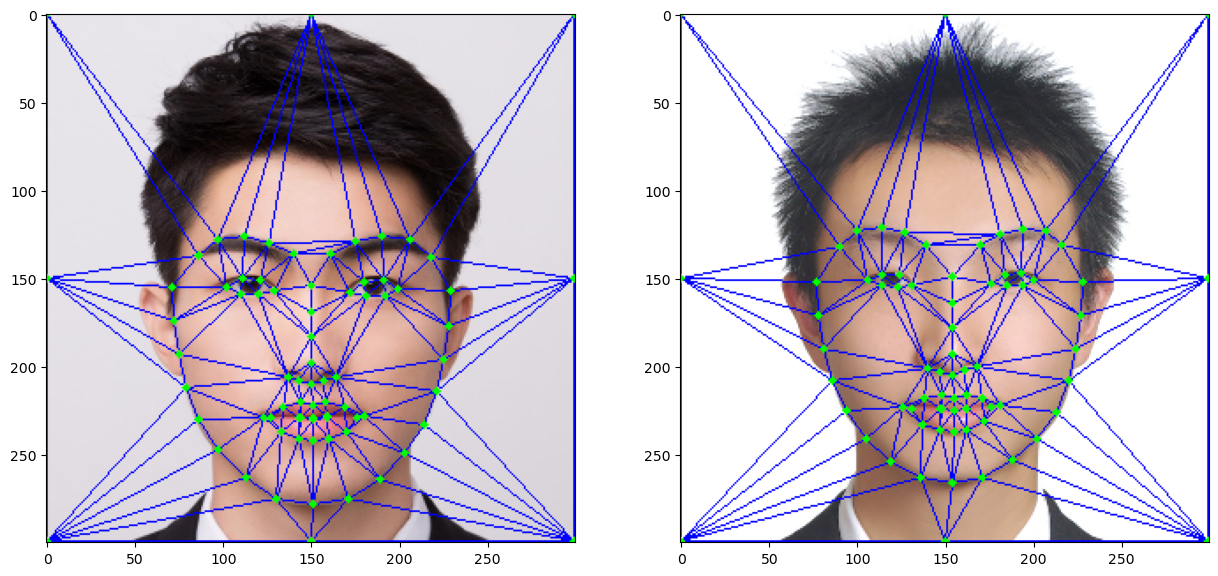

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))
display_triangulation(img1.copy(), points_1, tri_idx, axs[0])
display_triangulation(img2.copy(), points_2, tri_idx, axs[1])

# Linear Interpolate intermediate image coords
Create the intermediate image coordinates in all “in between” images for all the vertices of all triangles by linearly interpolating between the start and end positions.

In [92]:
# Calculate landmark points of all intermediate images
img_num = 50
intermediate_img_points = np.linspace(points_1, points_2, img_num)

# Estimate Affine Warp
For every pair of corresponding triangles, take the 3 pairs of corresponding vertices and estimate an Affine warp. You will need to solve a linear system of equations to estimate the parameters of the affine warp. You must write the code for this function yourself. Do not use a built-in function for this.  

Calculate the affine warp matrix. This is how affine warp works.
$$
\begin{bmatrix}
a & b & t_x\\
 c & d & t_y\\
 0 & 0 & 1
\end{bmatrix}  
\begin{bmatrix}
 x_i\\
 y_i\\
 1
\end{bmatrix}
= 
\begin{bmatrix}
 x_i'\\
 y_i'\\
 1
\end{bmatrix}
$$  
Then we have 3 pairs of points, which are 6 points in total. Then we have equations like this:  
$$
\left\{\begin{matrix}
ax_1+by_1+t_x=x_1' \\
cx_1+dy_1+t_y=y_1' \\
ax_2+by_2+t_x=x_2' \\
cx_2+dy_2+t_y=y_2' \\
ax_3+by_3+t_x=x_2' \\
cx_4+dy_3+t_y=y_2'
\end{matrix}\right.
\Rightarrow 
\begin{bmatrix}
 x_1 & y_1 & 0 & 0 & 1 & 0\\
 0 & 0 & x_1 & y_1 & 0 & 1\\
 x_2 & y_2 & 0 & 0 & 1 & 0\\
 0 & 0 & x_2 & y_2 & 0 & 1\\
 x_3 & x_3 & 0 & 0 & 1 & 0\\
 0 & 0 & x_3 & y_3 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
a \\
b \\
c \\
d \\
t_x \\
t_y
\end{bmatrix}=
\begin{bmatrix}
x_1' \\
y_1' \\
x_2' \\
y_2' \\
x_3' \\
y_3'
\end{bmatrix}\Rightarrow 
\mathbf{A} \mathbf{W} = \mathbf{X}
$$  
Where W is the affine warp matrix. We can get this matrix by calculating the inverse of A and left multiply on X.

In [93]:
def get_affine_matrix(src, tgt):
    matrix = np.eye(3)
    x1, y1 = src[0]
    x2, y2 = src[1]
    x3, y3 = src[2]
    nx1, ny1 = tgt[0]
    nx2, ny2 = tgt[1]
    nx3, ny3 = tgt[2]
    w = np.asarray([[x1, y1, 0, 0, 1, 0], 
                    [0, 0, x1, y1, 0, 1], 
                    [x2, y2, 0, 0, 1, 0], 
                    [0, 0, x2, y2, 0, 1], 
                    [x3, y3, 0, 0, 1, 0], 
                    [0, 0, x3, y3, 0, 1]])
    y = np.asarray([nx1, ny1, nx2, ny2, nx3, ny3]).T
    x = np.linalg.inv(w) @ y
    matrix[0][0] = x[0]
    matrix[0][1] = x[1]
    matrix[1][0] = x[2]
    matrix[1][1] = x[3]
    matrix[0][2] = x[4]
    matrix[1][2] = x[5]
    return matrix

Apply affine warp on new points.

In [94]:
def affine_warp(point, matrix):
    new_point = (matrix @ (np.hstack((point, 1))))[:2]
    return new_point

# Map points between triangles
Map all corresponding points between the triangles.This means, find the new coordinates for all the points in the triangle (before you only knew the position of the 3 vertices, with the affine transformation you can find ALL the correspondences!). Remember to use the inverse warp instead of the forward warp and use bilinear interpolation. You must write the code for this function yourself. Do not use a built-in function for this.  

Apply blending using the parameter w described above.

Judge whether a point is inside a triangle. Use cross product to decide whether the point is on the right of all edges, if positive then it is inside.

In [95]:
def isInside_tri(tri_points, point):
    ab = tri_points[1] - tri_points[0]
    ap = point - tri_points[0]
    bc = tri_points[2] - tri_points[1]
    bp = point - tri_points[1]
    ca = tri_points[0] - tri_points[2]
    cp = point - tri_points[2]
    cross1 = np.cross(ab, ap)
    cross2 = np.cross(bc, bp)
    cross3 = np.cross(ca, cp)
    if cross1 >= 0 and cross2 >= 0 and cross3 >= 0:
        return True
    else:
        return False

Implement bilinear interpolation on a float point. Use the equation on the slides.

In [96]:
def bilinear_interpolation(img, point):
    dx = point[1] - int(point[1])
    dy = point[0] - int(point[0])
    x = int(point[1])
    y = int(point[0])
    h, w = img.shape[:2]
    x_expand = x + 1 if x < h - 1 else x
    y_expand = y + 1 if y < w - 1 else y
    pixel = (dx * dy * img[x_expand, y_expand] + 
             dx * (1 - dy) * img[x_expand, y] + 
             (1 - dx) * dy * img[x, y_expand] + 
             (1 - dx) * (1 - dy) * img[x, y])
    return pixel

The core loop to generating intermediate images.  
For each image and each triangle, we alculate the affine warp matrix. Then use a rectangle to encircle the triangle, loop each point and judge whether it is inside the triangle, if positive then implement affine warp to get new points on both two target images. For each new point, we implement bilinear interpolation to get the actual pixel value. At last, multiply each pixel value with weight and one minus weight to be the final RGB value.

In [97]:
# Compute all Affine Warp matrix. For each intermediate image, has 2*triangle_num matrix to imageA and imageB
gen_imgs = []
for img_idx in range(1, img_num - 1):
    target_points = intermediate_img_points[img_idx]
    gen_img = np.zeros_like(img1)
    w = img_idx / (img_num - 1)
    for t_idx in range(len(tri_idx)):
        print("Generating Img[ %d / %d ] Triangle[ %d / %d ]" % (img_idx, img_num - 2, t_idx + 1, len(tri_idx)))
        target_tri_points = target_points[tri_idx[t_idx]].astype(np.float32)
        src_tri_points_A = points_1[tri_idx[t_idx]].astype(np.float32)
        src_tri_points_B = points_2[tri_idx[t_idx]].astype(np.float32)
        warp_matrix_A = get_affine_matrix(target_tri_points, src_tri_points_A)
        warp_matrix_B = get_affine_matrix(target_tri_points, src_tri_points_B)
        
        imin = int(target_tri_points[:,0].min())
        imax = int(target_tri_points[:,0].max())
        jmin = int(target_tri_points[:,1].min())
        jmax = int(target_tri_points[:,1].max())
        for i in range(imin ,imax + 1):
            for j in range(jmin, jmax + 1):
                point = np.asarray([i, j]).astype(np.float32)
                isInside = isInside_tri(target_tri_points, point)
                if isInside:
                    new_point_A = affine_warp(point, warp_matrix_A)
                    new_point_B = affine_warp(point, warp_matrix_B)
                    pixel_A = bilinear_interpolation(img1, new_point_A)
                    pixel_B = bilinear_interpolation(img2, new_point_B)
                    gen_img[j, i, :] = pixel_A * (1 - w) + pixel_B * w
                    
    gen_imgs.append(gen_img)

Generating Img[ 1 / 48 ] Triangle[ 1 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 2 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 3 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 4 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 5 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 6 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 7 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 8 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 9 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 10 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 11 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 12 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 13 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 14 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 15 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 16 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 17 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 18 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 19 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 20 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 21 / 142 ]
Generating Img[ 1 / 48 ] Triangle[ 22 / 142

Add the first image and the last image to generate video.

In [58]:
gen_imgs.insert(0, img1)
gen_imgs.append(img2)

Generate video with 10 FPS.

In [101]:
fps = 10
size = (300, 300)
video = cv.VideoWriter('Affine Warp.mp4', cv.VideoWriter_fourcc('I', '4', '2', '0'), fps, size)
for img in gen_imgs:
    video.write(img)
video.release()

Display the video.

In [103]:
from IPython.display import Video
Video('Affine Warp.mp4')